# Double Q-Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define environment parameters
start_position = [3, 0]  
goal = [3, 11]
world_width = 12
world_height = 4 
# actions
up = 0
left = 1
right = 2
down = 3
actions = [up, left, right, down]

In [2]:
class CliffWalking:
    def __init__(self, initial_state, goal_state):
        self.initial_state = initial_state
        self.goal_state = goal_state
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False

    def is_cliff(self):
        cliff = np.zeros((world_height, world_width), dtype=bool)
        cliff[3, 1: -1] = True
        return cliff[tuple(self.state)]

    # return next_state, reward, done
    def step(self, action):
        i, j = self.state

        if action == up:
            self.state = [max(i - 1, 0), j]
        elif action == left:
            self.state = [i, max(j - 1, 0)]
        elif action == right:
            self.state = [i, min(j + 1, world_width - 1)]
        elif action == down:
            self.state = [min(i + 1, world_height - 1), j]
        else:
            assert False, "Actions should be in the range of (0, 4)"

        if self.is_cliff():
            self.state = self.initial_state
            self.reward = -100.0
            self.is_terminal = False
        elif self.state == self.goal_state:
            self.state = self.state
            self.reward = 0.0
            self.is_terminal = True
        else:
            self.reward = -1.0
            self.is_terminal = False
        return self.state, self.reward, self.is_terminal

    def reset(self):
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False
        return self.state

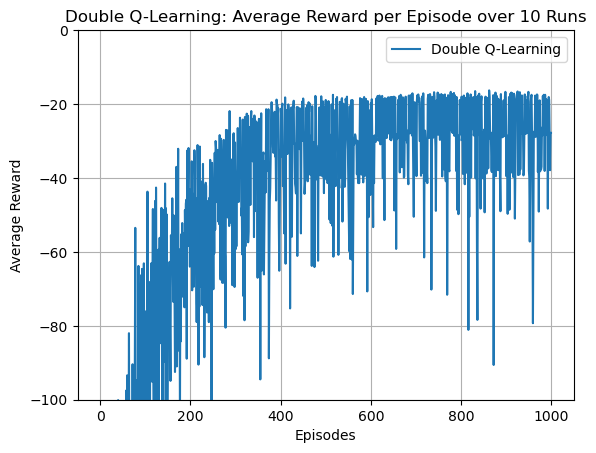

In [3]:
# Double Q-Learning Algorithm
def double_q_learning(env, episodes, runs, alpha=0.1, gamma=1, epsilon=0.1):
    total_rewards = np.zeros((runs, episodes))

    for run in range(runs):
        Q1 = np.zeros((world_height, world_width, len(actions)))
        Q2 = np.zeros((world_height, world_width, len(actions)))

        for episode in range(episodes):
            state = env.reset()
            done = False
            total_reward = 0

            while not done:
                
                # Epsilon Greedy
                if np.random.rand() < epsilon:
                    action = np.random.choice(actions)
                else:
                    action = np.argmax(Q1[state[0], state[1]] + Q2[state[0], state[1]])

                next_state, reward, done = env.step(action)
                total_reward += reward

                # Double Q-learning
                if np.random.rand() < 0.5:
                    # Update Q1
                    best_action = np.argmax(Q1[next_state[0], next_state[1]])
                    Q1[state[0], state[1], action] += alpha * (reward + gamma * Q2[next_state[0], next_state[1], best_action] - Q1[state[0], state[1], action])
                else:
                    # Update Q2
                    best_action = np.argmax(Q2[next_state[0], next_state[1]])
                    Q2[state[0], state[1], action] += alpha * (reward + gamma * Q1[next_state[0], next_state[1], best_action] - Q2[state[0], state[1], action])

                state = next_state

            total_rewards[run, episode] = total_reward

    return Q1, Q2, total_rewards

# Parameters
episodes = 1000
runs = 10
alpha = 0.1
gamma = 1
epsilon = 0.1

# Initialize environment
env = CliffWalking(start_position, goal)

# Run Double Q-Learning
Q1, Q2, total_rewards = double_q_learning(env, episodes, runs, alpha, gamma, epsilon)

# Calculate average rewards across runs
average_rewards = np.mean(total_rewards, axis=0)

# Plot the results
plt.plot(average_rewards, label='Double Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.ylim([-100,0])
plt.title('Double Q-Learning: Average Reward per Episode over 10 Runs')
plt.legend()
plt.grid(True)
plt.show()

As shown in the graph above, we can see that the average reward increases during the first 500 episodes. After that, the average reward stabilizes around -22. Overall, the oscillations are smaller than those in Q-learning and are larger to those in SARSA, but the time required to reach a stable state is longer than (nearly double) in both SARSA and Q-learning.

### 1. **The Number of Episodes to Reach Stable Stage: SARSA $\approx$ Q-learning = 1/2 * Double Q-learning**

The "stable stage" referring to is where the learning process has converged, and the agent is performing consistently, i.e., the average reward has plateaued. We are comparing how long it takes for SARSA, Q-learning, and Double Q-learning to reach this stable stage.

- **SARSA (State-Action-Reward-State-Action):** SARSA is an on-policy algorithm. It updates its Q-values based on the action actually taken, meaning that the agent evaluates and improves actions based on its own policy during training. Since SARSA is more conservative, and it’s trying to stick with the same policy it’s improving (the policy it’s actually following), it tends to take a little longer to converge to an optimal policy. 

- **Q-learning:** Q-learning is an off-policy algorithm. It updates its Q-values using the greedy action (i.e., the maximum Q-value) for the next state, regardless of which action the agent actually took. This leads to faster learning because the agent is learning from the best possible actions in each state, even if it doesn’t always follow that action in practice.

- **Double Q-learning:** Double Q-learning, as we learned earlier, is designed to reduce overestimation bias by using two separate Q-functions. While this can improve stability and performance in the long run, it comes with the tradeoff of requiring more episodes to converge to a stable solution. This happens because the dual Q-functions introduce additional complexity in the update process, leading to slower (approximate twice the Q-learning time) but more stable convergence.

So, when we say the number of episodes to reach the stable stage for each method:

- **SARSA and Q-learning** typically converge in a similar number of episodes, but SARSA might take slightly longer in some environments because it is more conservative in its updates (since it follows its own policy). However, the difference is usually not huge, and it's often context-dependent.
  
- **Double Q-learning** usually requires about twice as many episodes as Q-learning or SARSA to reach the stable stage because it needs to alternate between two Q-values, slowing down the convergence process compared to standard Q-learning or SARSA.


### 2. **Volatility of SARSA < Double Q-learning < Q-learning in the Stable Stage**

By volatility, we’re referring to the **fluctuations in the average reward** over time, particularly once the agent has reached the stable stage.

- **SARSA's Volatility:** Since SARSA is an on-policy algorithm and tends to follow the policy it is learning, it’s more cautious and incremental in its updates. This makes it more stable because it doesn't tend to overestimate values too much. As a result, SARSA’s average reward will have relatively **less volatility** in the stable stage. The policy it converges to is more consistent and less prone to large changes.

- **Double Q-learning’s Volatility:** Double Q-learning reduces the overestimation bias of Q-learning by using two Q-values for each state-action pair, which typically leads to smoother updates and more accurate value estimates. However, the two Q-values do create an additional layer of learning, which can introduce slight instability during the learning phase. This leads to **moderate volatility**. In the stable stage, the volatility is still higher than SARSA but lower than Q-learning.

- **Q-learning's Volatility:** Q-learning, as an off-policy algorithm, tends to have higher volatility in the learning process. The reason is that it always updates its Q-values based on the maximum estimated value (greedy updates), even if it’s not necessarily the best action in practice. This can lead to large overestimations and instability during learning, and **Q-learning tends to have the highest volatility** in the stable stage. It might overshoot in its updates, causing fluctuations in the average reward before stabilizing.


# Optimal Policy

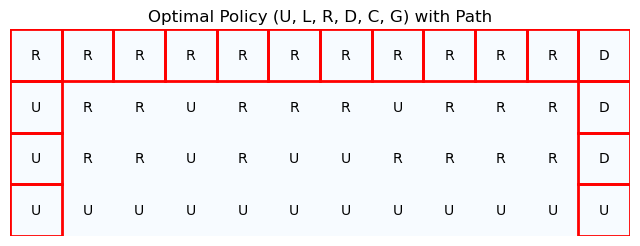

In [4]:
# Define action_symbols
action_symbols = ['U', 'L', 'R', 'D', 'C', 'G']

optimal_policy = np.zeros((world_height, world_width), dtype=str)

for i in range(world_height):
    for j in range(world_width):
        # Combine Q1 and Q2
        combined_q = Q1[i, j] + Q2[i, j]
        # Find action with highest Q
        optimal_action = np.argmax(combined_q)
        # Map the action index to its symbol
        optimal_policy[i, j] = action_symbols[optimal_action]

path = [(3, 0)]
current_position = (3, 0)

action_to_move = {
    'U': (-1, 0),
    'L': (0, -1),
    'R': (0, 1),
    'D': (1, 0),
    'C': (0, 0),  # Cliff
    'G': (0, 0)   # Goal
}

# Until reach [3, 11]
while current_position != (3, 11):
    action = optimal_policy[current_position[0], current_position[1]]
    move = action_to_move[action]
    next_position = (current_position[0] + move[0], current_position[1] + move[1])
    
    if 0 <= next_position[0] < world_height and 0 <= next_position[1] < world_width:
        path.append(next_position)
        current_position = next_position

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(np.zeros_like(optimal_policy, dtype=int), cmap='Blues', interpolation='nearest')

for i in range(world_height):
    for j in range(world_width):
        axes.text(j, i, optimal_policy[i, j], ha='center', va='center', color='black')

# Add red edge
for (i, j) in path:
    rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
    axes.add_patch(rect)

axes.set_title("Optimal Policy (U, L, R, D, C, G) with Path")
axes.axis('off')

plt.show()



The graph above is a classic illustration of the result, presented in the same format as in the seminar. The red edge also shows the optimal path for this Double Q-learning. Compared to the SARSA and Q-learning (shown below), double Q-learning's path is the least efficient one. However, this is expected and still a useful algorithm because Double Q-learning **outperforms Q-learning and SARSA** in scenarios where **overestimation bias is problematic**, such as environments with high variance in rewards. Although it may take longer to converge, it often results in a more **stable and accurate** policy in the long run.

# Extra: Sensitivity Test

## Test 1: Learning Rate (alpha)

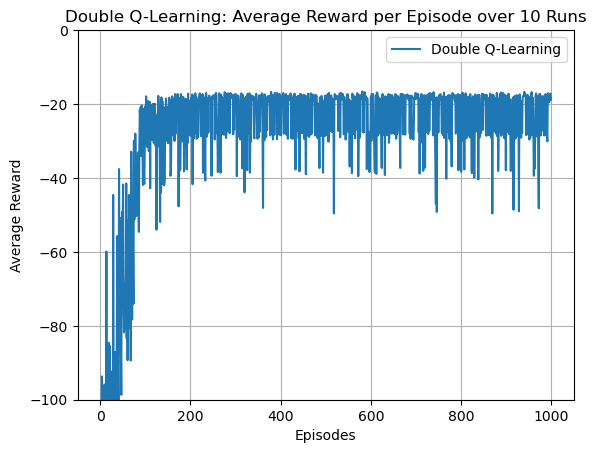

In [5]:
# Run Double Q-Learning
Q1, Q2, total_rewards = double_q_learning(env, episodes, runs, 0.5, gamma, epsilon)

# Calculate average rewards across runs
average_rewards = np.mean(total_rewards, axis=0)

# Plot the results
plt.plot(average_rewards, label='Double Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.ylim([-100,0])
plt.title('Double Q-Learning: Average Reward per Episode over 10 Runs')
plt.legend()
plt.grid(True)
plt.show()

If change alpha from 0.1 to 0.5, the average reward increases more rapidly in the initial stage and reaches a stable value faster. This is expected because of the following reasons:

In Double Q-Learning, there are two Q-value estimates, $ Q_1(s, a) $ and $ Q_2(s, a) $, representing two independent action-value functions. The update rule for Double Q-Learning is as follows:

1. **Q-Value Update for $ Q_1 $:**

$$
Q_1(s_t, a_t) \leftarrow Q_1(s_t, a_t) + \alpha \left[ r_t + \gamma Q_2(s_{t+1}, \text{argmax}_a Q_1(s_{t+1}, a)) - Q_1(s_t, a_t) \right]
$$

2. **Q-Value Update for $ Q_2 $:**

$$
Q_2(s_t, a_t) \leftarrow Q_2(s_t, a_t) + \alpha \left[ r_t + \gamma Q_1(s_{t+1}, \text{argmax}_a Q_2(s_{t+1}, a)) - Q_2(s_t, a_t) \right]
$$


Where:
- \( $s_t$ \) is the state at time $ t $,
- \( $a_t$ \) is the action taken at time $ t $,
- \( $r_t$ \) is the reward received after taking action $ a_t $,
- \( $\gamma$ \) is the discount factor,
- \( $\alpha$ \) is the learning rate,
- \( $Q_1$ \) and \( $Q_2$ \) are the two Q-value functions.


A higher learning rate means that the term \( $\alpha \left[ r_t + \gamma Q_2(s_{t+1}, \text{argmax}_a Q_1(s_{t+1}, a)) - Q_1(s_t, a_t) \right]$ \) will be larger. The Q-value update will be more sensitive and responsive to new information and changes in rewards. The agent will learn more quickly from each experience as the update steps are larger.

In essence, **alpha (α)** determines the size of the step taken during each update. Larger steps (higher alpha) mean faster, while smaller steps (lower alpha) mean slower.

## Test 2: Epsilon-Greedy Parameter (epsilon)

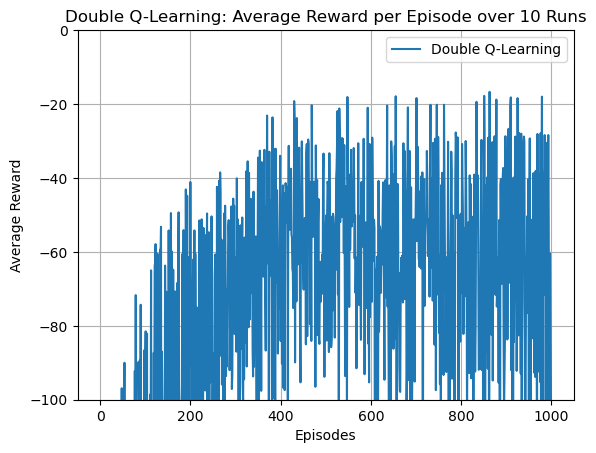

In [6]:
# Run Double Q-Learning
Q1, Q2, total_rewards = double_q_learning(env, episodes, runs, alpha, gamma, 0.2) # Epsilon from 0.1 to 0.2

# Calculate average rewards across runs
average_rewards = np.mean(total_rewards, axis=0)

# Plot the results
plt.plot(average_rewards, label='Double Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.ylim([-100,0])
plt.title('Double Q-Learning: Average Reward per Episode over 10 Runs')
plt.legend()
plt.grid(True)
plt.show()

In reinforcement learning (RL), epsilon (often denoted as $\epsilon$) refers to the exploration rate in algorithms (epsilon-greedy in this algorithm), where $\epsilon$ determines how frequently the agent explores random actions versus exploiting known best actions. A larger $\epsilon$ (more exploration) could result in a lower average reward, greater oscillations, and slower convergence to the stable stage in Double Q-learning.

### 1. **Epsilon-Greedy Exploration Strategy**: 
When $\epsilon$ is smaller, the agent primarily exploits its knowledge by choosing the action that it believes will lead to the highest reward (based on the current Q-values). This leads to less randomness in the agent's choices, and it tends to focus on refining and improving its policy over time. On the other hand, when $\epsilon$ is large, the agent frequently chooses random actions, leading to less exploitation of the best-known actions and more exploration. While exploration helps discover potentially better actions, it also means that the agent will sometimes choose suboptimal actions.

### 2. **Double Q-learning**:
In Double Q-learning, due to the overestimation bias being reduced, the agent still explores the state-action space but now has two different Q-value estimates. With a larger $\epsilon$, the agent frequently explores random actions, and both Q1 and Q2 are updated based on these suboptimal actions. As a result, the agent will frequently reinforce less optimal values, which can lead to slower convergence and oscillations between the two Q-values.

### Summary:
In Double Q-learning, increasing $\epsilon$ leads to more exploration, which can cause:
- **Lower average reward** due to frequent suboptimal actions.
- **Greater oscillations** in the Q-value estimates as both Q1 and Q2 are updated based on random actions, reducing stability.
- **Slower convergence** as the agent spends more time exploring and less time exploiting, which delays the discovery of the optimal policy and increases instability in the Q-values. 

This trade-off between exploration and exploitation is central to RL, and while a larger $\epsilon$ can help in discovering better policies, it comes at the cost of performance in the short term.

# Reference: SARSA & Q-Learning

In [7]:
def eps_greedy_policy(qsa, epsilon=0.1):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice(actions)
    else:
        return np.random.choice([action_ for action_, value_ in enumerate(qsa) if value_ == np.max(qsa)])

def sarsa(qsa, next_qsa, r, alpha=0.1, gamma=1.0):
    return qsa + alpha * (r + gamma * next_qsa - qsa) # State-action value function for policy evaluation

def q_learning(qsa, next_qs, r, alpha=0.1, gamma=1.0):  
    return qsa + alpha * (r + gamma * np.max(next_qs) - qsa)

In [8]:
env_sarsa = CliffWalking(start_position, goal)
env_q_learning = CliffWalking(start_position, goal)

runs = 10
episodes = 1000
rewards_sarsa = np.zeros(episodes)
rewards_qlearning = np.zeros_like(rewards_sarsa)

# Create two instances of the environments for comparison
env_sarsa = CliffWalking(start_position, goal)
env_q_learning = CliffWalking(start_position, goal)

for r in range(runs):
    q_sarsa = np.zeros((world_height, world_width, len(actions)))
    q_qlearning = np.zeros_like(q_sarsa)

    for i in range(episodes):
        state_sarsa = env_sarsa.reset()
        state_q = env_q_learning.reset()

        done_sarsa = False
        done_q = False

        # choose an action based on current state
        row, col = state_sarsa
        a_sarsa = eps_greedy_policy(q_sarsa[row, col, :])
        g_sarsa = 0.0
        g_q = 0.0
        
        #Sarsa
        while not done_sarsa:
            next_state_sarsa, r_sarsa, done_sarsa = env_sarsa.step(a_sarsa)
        
            # choose an action for the next state
            row, col = state_sarsa
            n_row, n_col = next_state_sarsa
            next_a_sarsa = eps_greedy_policy(q_sarsa[n_row, n_col, :])
            g_sarsa += r_sarsa
            # sarsa updates
            q_sarsa[row, col, a_sarsa] = sarsa(q_sarsa[row, col, a_sarsa], q_sarsa[n_row, n_col, next_a_sarsa], r_sarsa)

            state_sarsa = next_state_sarsa
            a_sarsa = next_a_sarsa
            
        #Q-Learning
        while not done_q:
            row_q, col_q = state_q
            a_q = eps_greedy_policy(q_qlearning[row_q, col_q, :])
            next_state_q, r_q, done_q = env_q_learning.step(a_q)
            g_q += r_q

            # Q-learning updates, note the second argument
            n_row_q, n_col_q = next_state_q
            q_qlearning[row_q, col_q, a_q] = q_learning(q_qlearning[row_q, col_q, a_q],
                                                        q_qlearning[n_row_q, n_col_q, :], r_q)
            state_q= next_state_q
            
        rewards_sarsa[i] += g_sarsa
        rewards_qlearning[i] += g_q

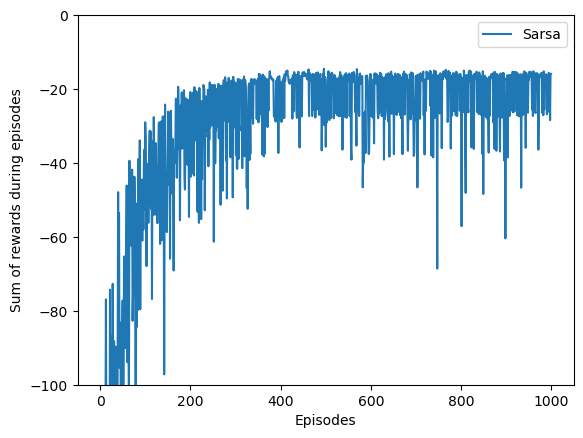

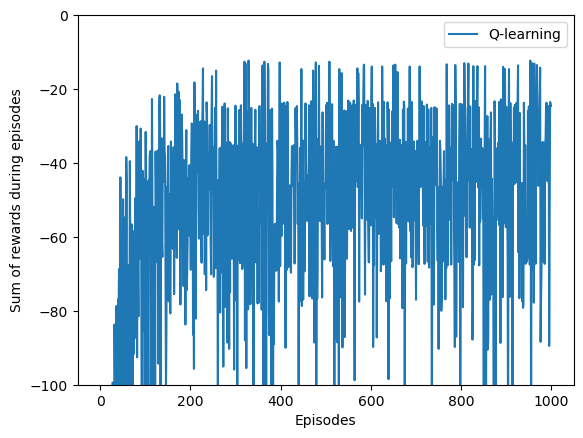

In [9]:
import matplotlib.pyplot as plt
def plot_rewards(plots):
    plt.figure()
    for plot in plots:
        method, method_title = plot
        plt.plot(method, label=method_title)
    # plt.plot(r_qlearning, label='Q-learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episodes')
    plt.ylim([-100, 0])
    plt.legend()
    plt.show()


rewards_sarsa /= runs
rewards_qlearning /= runs

plot_rewards([[rewards_sarsa, 'Sarsa']])
plot_rewards([[rewards_qlearning, 'Q-learning']])

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def print_optimal_policy(policy, method, start_position, q_values):
    # First, print the policy as before
    policy_display = np.empty_like(policy, dtype=str)
    
    # Create the basic policy display with U, D, L, R
    for i in range(0, world_height):
        for j in range(0, world_width):
            if [i, j] == [3, 11]:  # Goal state
                policy_display[i, j] = 'G'
                continue
            if i == 3 and j in np.arange(1, 11):  # Cliff region
                policy_display[i, j] = 'C'
                continue
            a = policy[i, j]
            if a == up:
                policy_display[i, j] = 'U'
            elif a == left:
                policy_display[i, j] = 'L'
            elif a == right:
                policy_display[i, j] = 'R'
            elif a == down:
                policy_display[i, j] = 'D'

    # Print the optimal policy
    print(f"{method} Optimal policy is:")
    for row in policy_display:
        print(' '.join(row))

    # Trace the path from start_position and mark it with arrows
    path = []
    current_position = start_position
    while current_position != [3, 11]:  # Until we reach the goal
        i, j = current_position
        a = policy[i, j]
        path.append(current_position)
        
        if a == up:
            current_position = [i - 1, j]
        elif a == down:
            current_position = [i + 1, j]
        elif a == left:
            current_position = [i, j - 1]
        elif a == right:
            current_position = [i, j + 1]

    # Mark the path with arrows on the display
    for i, j in path:
        if policy_display[i, j] not in ['G', 'C']:  # Don't overwrite goal or cliff
            # Determine the arrow based on the optimal action
            a = policy[i, j]
            if a == up:
                policy_display[i, j] = '↑'
            elif a == down:
                policy_display[i, j] = '↓'
            elif a == left:
                policy_display[i, j] = '←'
            elif a == right:
                policy_display[i, j] = '→'

    # Print the policy display with the path marked
    print("\nOptimal policy with path:")
    for row in policy_display:
        print(' '.join(row))


# For SARSA
optimal_policy_sarsa = np.argmax(q_sarsa, axis=2)
print_optimal_policy(optimal_policy_sarsa, 'SARSA', start_position, q_sarsa)

# For Q-Learning
optimal_policy_qlearning = np.argmax(q_qlearning, axis=2)
print_optimal_policy(optimal_policy_qlearning, 'Q-Learning', start_position, q_qlearning)


SARSA Optimal policy is:
R R R D R R D R R R R D
R R R R R R R R R R R D
U R U U R R R R R U R D
U C C C C C C C C C C G

Optimal policy with path:
R R R D R R D R R R R D
→ → → → → → → → → → → ↓
↑ R U U R R R R R U R ↓
↑ C C C C C C C C C C G
Q-Learning Optimal policy is:
D L U R R R D D R R R D
R U D R R R R D D D R D
R R R R R R R R R R R D
U C C C C C C C C C C G

Optimal policy with path:
D L U R R R D D R R R D
R U D R R R R D D D R D
→ → → → → → → → → → → ↓
↑ C C C C C C C C C C G
